#  EDA
## Overview

Below is *draft and unfinished* EDA.  My data has two sets of weights, which has slowed me down. I've asked the Springboard community for some clarity on how to handle the two different sets of weights in a principled way (see my forum question at https://dscareercommunity.springboard.com/t/63b2p4).

I'll then dig into other variables against poverty status, income ('NYCgov_Income') and poverty threshold as appropriate.  Those variables include: Borough, Total Work Hours by Poverty Unit, Usual Hours Worked, Weeks Worked Past 12 Months, Salary/Wages, Disability Status, Ethnicity, Citizenship Status, Family Type, Ability to Speak English, Employment Status, Housing Status, Housing Tenure, Rent, Number of People in Household, Educational Attainment, and Sex.

Once I've reviewed the data for 2016, I'll quickly compare across years to see any broad outlines of interesting details.

My request for review here is to broadly see whether I'm on track, if there are any mistakes in either thinking/ methodology or calculations that jump out at you.

I'm pretty comfortable with the 'Housekeeping part 1' and 'Housekeeping part 2' sections, since I've already used them in my data storytelling. The section entitled 'The Poverty Calculation' about a third of the way down this page is where the EDA really starts.

Data storytelling section for your reference:

(https://github.com/c74p/Springboard/blob/master/Capstone%20Project%201%20-%20Poverty/LookAtThis.ipynb).  


## The Dataset

* Data from https://data.cityofnewyork.us/browse?q=poverty
* 12 annual data files, from 2005 to 2016 inclusive (e.g. NYCgov_Poverty_Measure_Data__2016_.csv)
* CSV files with ~80 columns and ~60,000 rows each
* Each file had essentially the same format and contained (mostly) the same information
* Data types included:
    * Classification types encoded as integers (e.g. 1 if in poverty, 2 if not in poverty)
    * Floats for financial data (e.g. wages for the calendar year)

## Housekeeping part 1: imports and file prep

In order to make charts more easily, after importing we'll make some quick modifications to the data.

In [60]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, hsv_to_rgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chisquare
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('data/all_years.csv', index_col=0)

# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

In [2]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

# Create a dataframe 'cats' that uses categorical coding, rather than numerical coding, based on the dictionaries above.
cats = df.replace(nyc_codes)
cats = cats.replace(raw_codes)
cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 
                     'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}, 
                     'AgeCateg': {1: 'U18', 2:'18-64', 3:'65+'}})

# Update one column so that NA's are all in one category
cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

In [4]:
# Key dataframes of interest

# cats is already listed above - dataframe with all of the category variables un-encoded

# All 2016 data
all_2016 = df[df.Year == 2016]

# 2016 data for poverty units only
# For example, the data dictionary, sheet "Column Info", cell D81, says in relation to calculating the poverty gap:
# "retain only the reference person of each family in poverty (Povunit_Rel==1 & NYCgov_Poverty == 1)"
pu_2016 = df[(df.Year == 2016) & (df.Povunit_Rel == 1)]

# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
personal_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'NYCgov_EITC', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork', 'PWGTP'] 
pu_vars = ['MRGP_adj', 'RNTP_adj', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'WGTP']
other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year']

In [ ]:
# Many variables are actually categorical variables, but are represented by numbers
# Here we'll split out which are really categorical, and which are really numeric
#categorical_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork']
#numeric_vars = ['NYCgov_EITC', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', ]
#household_vars = ['NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'WGTP', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', ]
#other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year', 'PWGTP', ]

## Housekeeping part 2: helper functions

In [5]:
def df_for_pov_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of weighted poverty rate by a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

def df_for_pov_chart_nocats(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe (from a dataframe of numeric-only categories) of weighted poverty rate by 
    a single category in a column. 
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 1, ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    pcts = pcts.rename(columns={1: 'Pov', 2: 'No Pov'})
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

def df_for_stat_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', [column, weights_column]].groupby(column).sum()
    else:
        counts = dataframe[[column, weights_column]].groupby(column).sum()
        
    # count and create % by column    
    subtotals = counts.sum(level=0)
    pcts = subtotals/sum(counts[weights_column])
    
    # only return the % in poverty by column
    return pcts

def scatter_combined(dataframe, column, ylim=35):
    '''Create a scatter plot of weighted poverty rate by a single column, all years combined.
    Input: a dataframe, a column name, and an optional upper y-limit for the chart.
    Output: no return value. Plots a scatter plot.'''
    
    # Set up initial variables
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create counts and percentages by column
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts = pcts.rename(columns={'Pov': 'Weighted Poverty Rate by ' + str(column) + ', All Years Combined'})

    # Show the chart
    chart = sns.scatterplot(data=pcts)
    chart.set_ylim(0,ylim)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    pass

def scatter_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple scatter plots of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
            
def scatter_sub_stat(dataframe, column, years=[2005, 2010, 2016], ylimits=[0,0.25]):
    '''Create multiple scatter plots of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y=weight, title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()])
            ax.set_ylim(ylimits[0], ylimits[1])
            
def bar_combined(dataframe, column):
    '''Create a bar chart of weighted poverty rate by a single column, all years combined.
    Input: a dataframe and a column name.
    Output: no return value. Plots a bar chart.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts.plot.bar(title='Weighted Poverty Rate by ' + str(column) + ', All Years Combined', legend=None, color='bgrcymk')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    
def bar_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
        
def bar_sub_stat(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

In [6]:
def ecdf(x):
    return np.arange(1, len(x)+1) / len(x)

def ecdf_plot(x):
    x_sorted = sorted(x)
    plt.plot(x_sorted, ecdf(x_sorted), marker='.', linestyle='none')

## The Poverty Calculation

* New York City has its own poverty calculation, detailed at https://www1.nyc.gov/site/opportunity/poverty-in-nyc/poverty-measure.page.
* The poverty calculation is **NYCgov_Income vs NYCgov_Threshold**, and is calculated at a poverty-unit level rather than at a person (individual) level.
* Think of a poverty unit as roughly like a household, but consider that there can be more than one poverty unit in a household - for example, if you have a single parent with one child renting space in an elderly couple's house (where the elderly couple also lives), these are two separate poverty units.
* I will continually distinguish between poverty-unit variables and person-level (individual) variables, as they have distinct sets of weights.


* **NYCgov_Threshold** is the official US poverty threshold ('Off_Threshold'), with an adjustment for housing costs.
    * The official poverty threshold is set by the US government, and the housing cost calculation is intended to compensate for the higher cost of housing in New York City.
    * **We will consider the NYC poverty threshold as fixed for each particular poverty unit for purposes of our analysis**, since the data to compute the housing cost adjustment is not available.
        * The calculations of the threshold and the housing cost adjustment are summarized at https://www1.nyc.gov/assets/opportunity/pdf/Appendix%20B%20-%20NYCgovPovMeas18.pdf and https://www1.nyc.gov/assets/opportunity/pdf/Appendix%20C%20-%20NYCgovPovMeas18.pdf.
    
    
* **NYCgov_Income** is income minus costs: 
    
    **(PreTaxIncome_PU – NYCgov_IncomeTax – NYCgov_FICAtax) +
    (NYCgov_SNAP + NYCgov_WIC + NYCgov_SchoolBreakfast + NYCgov_SchoolLunch) +
    NYCgov_HEAP +
    NYCgov_Housing -
    (NYCgov_Commuting + NYCgov_Childcare + NYCgov_MOOP)**


* Note that in the terms above, the prefix 'NYCgov_' simply means that this value was calculated by the NYC Poverty Research team.  It does not necessarily mean that the government of NYC has any impact on the value.

## A first look at correlations with NYCgov_Income

So, which of the variables above have the most impact on NYCgov_Income? Below is a list of all the correlations:
* PreTaxIncomePU (which is poverty unit income before taxes) has the strongest correlation with NYCgov_Income, as you would expect.
* NYCgov_IncomeTax and NYCgov_FICAtax are dependent variables, so we'll ignore them.
* The next highest correlations are with NYCgov_MOOP (total poverty unit medical spending), NYCgov_Commuting (poverty unit commuting costs), NYCgov_Childcare (poverty unit childcare costs), and NYCgov_HEAP (poverty unit heating assistance - negative correlation with NYCgov_Income).
***

In [6]:
pov_calc_vars = ['NYCgov_Income', 'PreTaxIncome_PU', 'NYCgov_IncomeTax', 'NYCgov_FICAtax', 'NYCgov_SNAP', 'NYCgov_WIC', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Commuting', 'NYCgov_Childcare', 'NYCgov_MOOP', 'WGTP']

temp = pu_2016.copy()
temp = temp[pov_calc_vars]

calc = pd.DataFrame(DescrStatsW(temp, temp.WGTP).corrcoef, index=temp.columns, columns=temp.columns).NYCgov_Income

print('Weighted Correlations with NYCgov_Income:')
print(calc.reindex(calc.abs().sort_values(ascending=False).index).tail(-1))

Weighted Correlations with NYCgov_Income:
PreTaxIncome_PU           0.982644
NYCgov_IncomeTax          0.930597
NYCgov_FICAtax            0.917120
NYCgov_MOOP               0.439180
NYCgov_Commuting          0.279513
NYCgov_Childcare          0.179909
NYCgov_HEAP              -0.172440
NYCgov_SNAP              -0.083106
NYCgov_SchoolLunch       -0.054682
NYCgov_SchoolBreakfast   -0.046473
NYCgov_WIC               -0.038135
NYCgov_Housing           -0.017215
WGTP                     -0.012472
Name: NYCgov_Income, dtype: float64


## A broader look at NYCgov_Income

We have lots of other poverty-unit variables that we didn't consider above. Let's look at how all of the key poverty-unit 'input' variables correlate with NYCgov_Income, ignoring things like taxes and poverty thresholds.

The top-ten list is below, sorted by absolute value of correlation in descending order:
* Again PreTaxIncome_PU tops the list.
* TotalWorkHrs_PU (total work hours for the poverty unit) has a strong negative correlation with income.
* NYCgov_MOOP, NYCgov_MedPremiums, and NYCgov_MedSpending are all medical expenses - the first one is the total, so we'll focus on that one.
* FamType_PU is family type (single parent, family, couple/no kids, etc.).
* MRGP_adj is mortgage payment.
* HHT is household type (similar to FamType_PU).
* HousingStatus is whether they own or rent, if their rent is subsidized, etc.
* Again NYCgov_Commuting is commuting costs.

***

In [8]:
temp = pu_2016.copy()

# Filter out some variables so we can focus on variables of interest
vars_of_interest = [var for var in pu_vars if not var in ['Off_Pov_Stat', 'Off_Threshold', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'NYCgov_Pov_Stat', 'NYCgov_Threshold']]
temp = temp[vars_of_interest]

calc = pd.DataFrame(DescrStatsW(temp, temp.WGTP).corrcoef, index=temp.columns, columns=temp.columns).NYCgov_Income
print('Weighted Correlations with NYCgov_Income:')
print(calc.reindex(calc.abs().sort_values(ascending=False).index).tail(-1).head(10))

Weighted Correlations with NYCgov_Income:
PreTaxIncome_PU       0.982644
TotalWorkHrs_PU      -0.451505
NYCgov_MOOP           0.439180
NYCgov_MedPremiums    0.358536
NYCgov_MedSpending    0.353822
FamType_PU           -0.352126
MRGP_adj              0.295846
HHT                  -0.295571
HousingStatus         0.285180
NYCgov_Commuting      0.279513
Name: NYCgov_Income, dtype: float64


***
### Age and Poverty Status in 2016

To give a baseline for what we'll be looking at here, let's take a look at the overall distribution of the NYCgov_Income
(again, this is poverty unit data, the key variable in the poverty calculation).  

We see below that the mean NYCgov_Income is about \\$56,900.  About 70\% of NYCgov_Income values fall between \\$0 and \\$118,000.
***

Description of NYCgov_Income:
Weighted mean: $56,898.20
Weighted std: $61,450.73


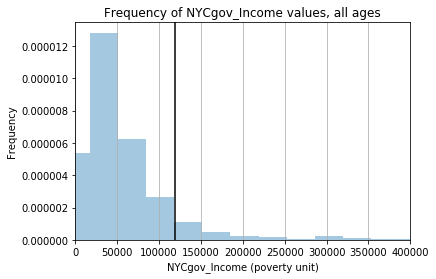

In [123]:
temp = pu_2016
title = 'Frequency of NYCgov_Income values, all ages' 
ax = sns.distplot(temp.NYCgov_Income, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
ax.grid(which='major', axis='x')
ax.set_xlim(0,400000)
ax.set_xlabel('NYCgov_Income (poverty unit)')
ax.set_ylabel('Frequency')
ax.set_title(title)
plt.axvline(x=118348.93, color='k')
print('Description of NYCgov_Income:')
print('Weighted mean: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Income, weights=temp.WGTP).mean))
print('Weighted std: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Income, weights=temp.WGTP).std))

***
### Age and Poverty Status in 2016: Young people

Now let's take a step back and look at poverty status by poverty units *headed by* someone of a given age. In particular, 18-year-olds that live with their parents much like they did when they were 14, sharing expenses, are not included here. 

As a result, poverty rates are pretty exorbitant for younger ages - it's not until age 25 that poverty rates begin to stabilize around the 20% rate seen in the general population.
***

Correlation for 18-29 years old: -0.913
Linear regression for 18-29 years old: -6.40 * x + 192.87
Correlation for 30+ years old: 0.780
Linear regression for 30+ years old: 0.19 * x + 10.18


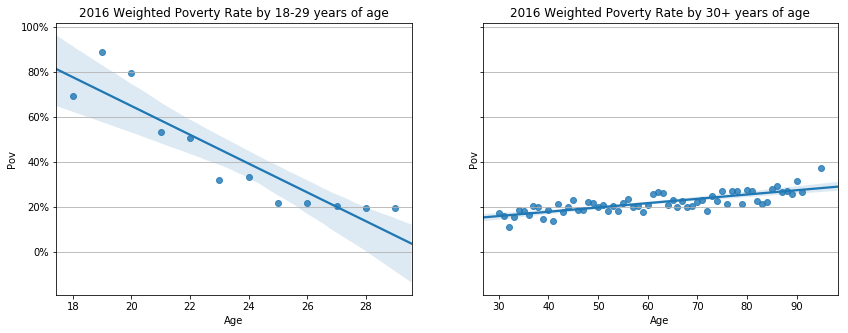

In [103]:
# Set up variables
n = 0
column = raw_inp_vars[n]
year = 2016
#pcts = df_for_pov_chart_nocats(hhonly_2016, raw_inp_vars[n], 'PWGTP')
pcts = df_for_pov_chart_nocats(pu_2016, raw_inp_vars[n], 'WGTP')
pcts_18_29 = pcts[3:15]
pcts_30plus = pcts[15:]
pcts_18_29.reset_index(inplace=True)
pcts_30plus.reset_index(inplace=True)
m_young, b_young = np.polyfit(pcts_18_29.AGEP, pcts_18_29.Pov, 1)
m_old, b_old = np.polyfit(pcts_30plus.AGEP, pcts_30plus.Pov, 1)


# Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)
for year in range(2):
    # initialize variables
    pcts = [pcts_18_29, pcts_30plus][year] 
    group = ['18-29 years', '30+ years']
    m, b = [(m_young, b_young), (m_old, b_old)][year]
    
    # Create regressions
    m, b = np.polyfit(pcts.AGEP, pcts.Pov, 1)
    
    ax = sns.regplot(data=pcts, x=column, y='Pov', ax=axes[year], color=sns.color_palette()[0])#, ci=None)
    ax.set_xlabel('Age')
    ax.set_title('2016 Weighted Poverty Rate by ' + group[year] + ' of age')
    print('Correlation for ' + str(group[year]) + ' old: ' + '{:4.3f}'.format(pcts.corr().iloc[0,1]))
    ax.grid(which='major', axis='y')
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
    print('Linear regression for ' + str(group[year]) + ' old: ' + '{:4.2f}'.format(m) + ' * x + ' + '{:4.2f}'.format(b))

***
You can see in the plots below that NYCgov_Income varies dramatically at early ages for the heads of poverty units (plotted at ages 19, 22, and 25, and at age 40 for comparison to an older group).  
***

Mean of NYCgov_Income at age 19 : $6,621.40
Mean of NYCgov_Income at age 22 : $18,859.74
Mean of NYCgov_Income at age 25 : $37,548.28
Mean of NYCgov_Income at age 40 : $65,605.39


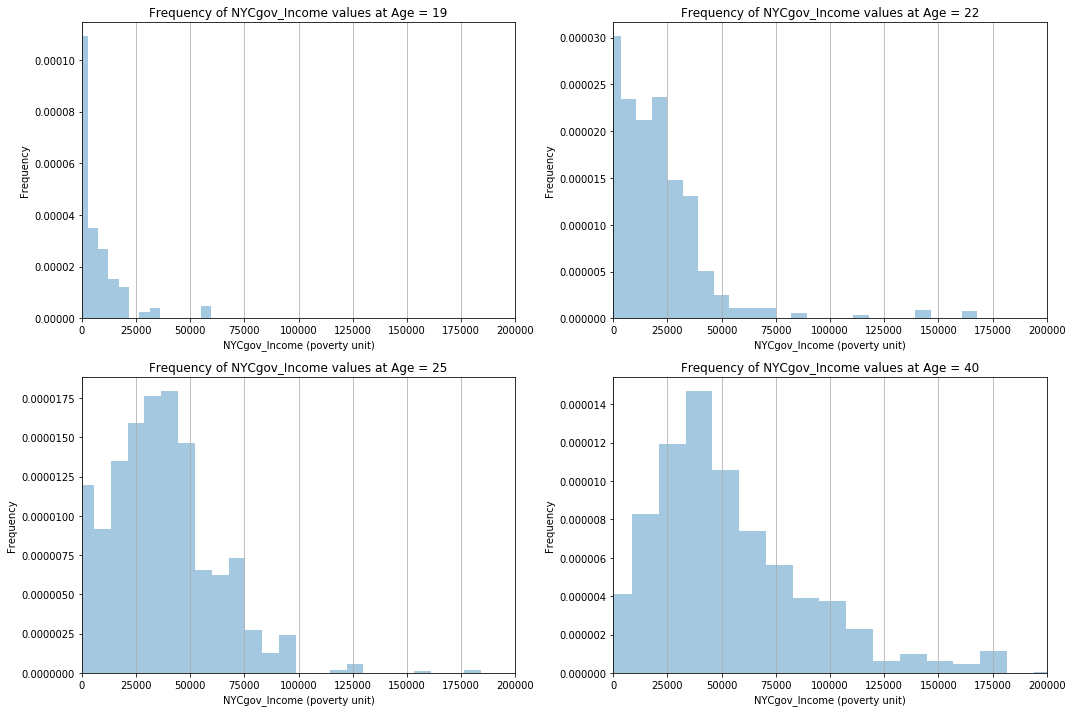

In [150]:
groups = [19, 22, 25, 40]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age]
    print('Mean of NYCgov_Income at age ' + str(age) + ' : ' + '${:6,.2f}'.format(temp.NYCgov_Income.mean()))
    title = 'Frequency of NYCgov_Income values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    ax = sns.distplot(temp.NYCgov_Income, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
    ax.grid(which='major', axis='x')
    ax.set_xlim(0,200000)
    ax.set_xlabel('NYCgov_Income (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
plt.tight_layout()

***
So the charts above are pretty convincing, but what do the statistics say?  Below we run t-tests for equality of means.

In each, our sample is poverty units headed by a person of age x.  Our statistic is mean NYCgov_Income for the poverty unit.

In nearly all cases, the p-value is zero to three significant digits, indicating strong likelihood of different means even when we're comparing two samples of people only one year apart (e.g. 19 years of age versus 18 years of age).  There are a few exceptions, but the overall point stands: there is a significant difference in mean income between poverty units headed by people of different ages.

Surprisingly, I re-ran the tests for ages 38-41 and ages 48-51, expecting to not see a significant difference; however, in both of these age ranges, the differences were also significant.  This cautions us to not read too much into the results, as a chart of NYCgov_Income by ages 38-41 don't look very different; however, the overall point still stands. 
***

In [97]:
ages = list(range(18,31))

for age1 in ages:
    one = pu_2016[pu_2016.AGEP == age1]
    two = pu_2016[pu_2016.AGEP == age1 - 1]
    comp = CompareMeans.from_data(one.NYCgov_Income, two.NYCgov_Income, weights1=one.WGTP, weights2=two.WGTP)
    print('Comparing age ' + str(age1) + ' to age ' + str(age1-1) + ': ' + str(comp.summary()))

Comparing age 18 to age 17:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   6289.2078    981.400      6.408      0.000    4364.655    8213.760
Comparing age 19 to age 18:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -1.115e+04    404.392    -27.571      0.000   -1.19e+04   -1.04e+04
Comparing age 20 to age 19:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   6083.4721    217.589     27.959    

***
Ok, so poverty units with younger heads have lower incomes, and that would be consistent with higher poverty rates.  But what about the poverty thresholds?  Even though we're considering them as fixed, maybe the poverty thresholds are higher for poverty units with younger heads?  

First, let's look at the whole group. The minimum poverty threshold is \\$15,017.13, the weighted mean is \\$23,300, and roughly 70\% of poverty units have poverty thresholds below \\$33,033. 
***

count    29595.000000
mean     23689.106554
std       9969.261856
min      15017.129826
25%      15017.129826
50%      21174.153055
75%      32401.999699
max      85509.389856
Name: NYCgov_Threshold, dtype: float64
Description of NYCgov_Threshold:
Weighted mean: $23,305.12
Weighted std: $9,728.32


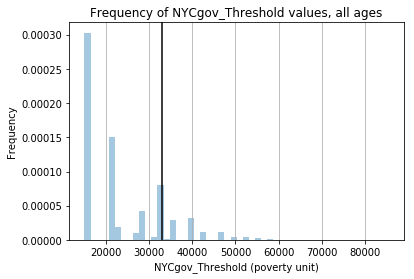

In [126]:
temp = pu_2016
title = 'Frequency of NYCgov_Threshold values, all ages' 
ax = sns.distplot(temp.NYCgov_Threshold, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
ax.grid(which='major', axis='x')
ax.set_xlabel('NYCgov_Threshold (poverty unit)')
ax.set_ylabel('Frequency')
plt.axvline(x=33033.44, color='k')
ax.set_title(title)

print(temp.NYCgov_Threshold.describe())
print('Description of NYCgov_Threshold:')
print('Weighted mean: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Threshold, weights=temp.WGTP).mean))
print('Weighted std: ' + '${:8,.2f}'.format(DescrStatsW(temp.NYCgov_Threshold, weights=temp.WGTP).std))

***
As you can see in the charts below, poverty thresholds actually tend to increase with increase age of the head of the
poverty unit in these younger poverty units.
***

Mean of NYCgov_Threshold at age 19 : $16,145.79
Mean of NYCgov_Threshold at age 22 : $16,812.36
Mean of NYCgov_Threshold at age 25 : $18,759.74
Mean of NYCgov_Threshold at age 40 : $27,290.71


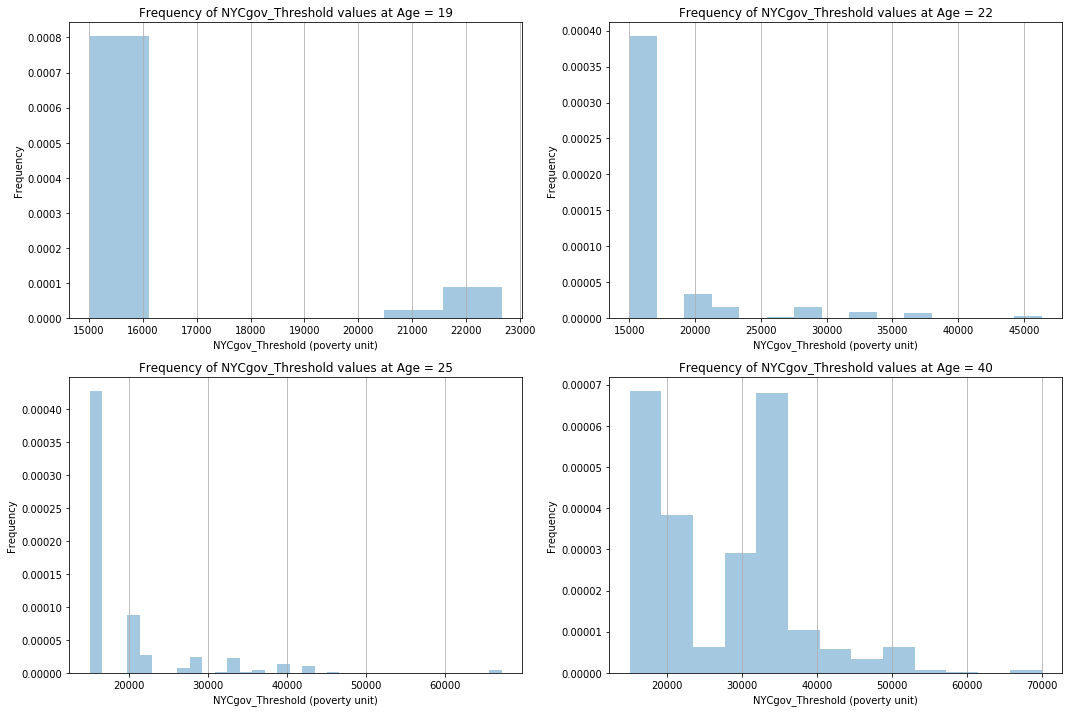

In [151]:
groups = [19, 22, 25, 40]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age]
    print('Mean of NYCgov_Threshold at age ' + str(age) + ' : ' + '${:6,.2f}'.format(temp.NYCgov_Threshold.mean()))
    title = 'Frequency of NYCgov_Threshold values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    ax = sns.distplot(temp.NYCgov_Threshold, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False) 
    ax.grid(which='major', axis='x')
    #ax.set_xlim(0,200000)
    ax.set_xlabel('NYCgov_Threshold (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
plt.tight_layout()

***
Again, the means tests confirm our visuals, as each p-value is zero to 3 significant digits.  The poverty thresholds are
not the same across age groupings. For poverty units with younger heads, the poverty unit income (NYCgov_Income) is the
key correlator with poverty.
***

In [105]:
ages = list(range(18,31))

for age1 in ages:
    one = pu_2016[pu_2016.AGEP == age1]
    two = pu_2016[pu_2016.AGEP == age1 - 1]
    comp = CompareMeans.from_data(one.NYCgov_Threshold, two.NYCgov_Threshold, weights1=one.WGTP, weights2=two.WGTP)
    print('Comparing age ' + str(age1) + ' to age ' + str(age1-1) + ': ' + str(comp.summary()))

Comparing age 18 to age 17:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   2126.1496    402.820      5.278      0.000    1336.208    2916.092
Comparing age 19 to age 18:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -3759.7186    138.371    -27.171      0.000   -4030.963   -3488.474
Comparing age 20 to age 19:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1    743.8148     55.828     13.323    

***
What about older poverty units? The chart below looks essentially linear, with a notable outlier at 95 years of age.  

But the issue is that even if the chart is linear, the poverty rates keep going up. In particular, among poverty units 
headed by someone between the ages of 30 and 60, none of them have poverty rates above 25%. But over half of the cohorts of poverty units headed by someone aged 60-95 have poverty rates over 25%.  Why?
***

            Pov
AGEP           
88    27.226099
89    25.937500
90    31.546880
91    26.801301
95    37.471398
Correlation for 30+ years old: 0.780
Linear regression for 30+ years old: 0.19 * x + 10.18
Correlation for 60+ years old: 0.587
Linear regression for 60+ years old: 0.24 * x + 6.74


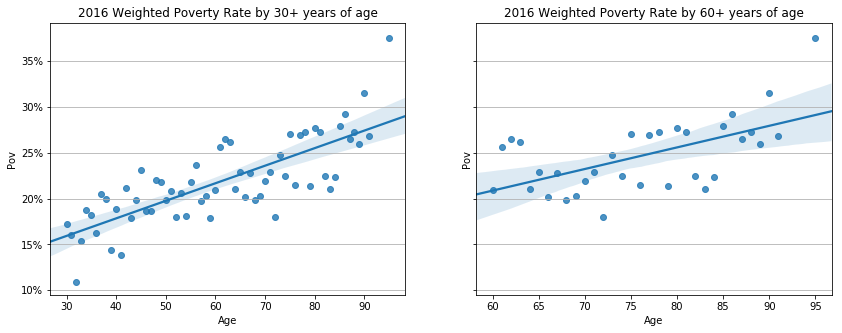

In [143]:
# Set up variables
n = 0
column = raw_inp_vars[n]
year = 2016
pcts = df_for_pov_chart_nocats(pu_2016, raw_inp_vars[n], 'WGTP')
#pcts_18_29 = pcts[15:45]
pcts_30plus = pcts[15:]
pcts_60plus = pcts[45:]
print(pcts_30plus.tail())
pcts_30plus.reset_index(inplace=True)
pcts_60plus.reset_index(inplace=True)
m_young, b_young = np.polyfit(pcts_30plus.AGEP, pcts_30plus.Pov, 1)
m_old, b_old = np.polyfit(pcts_60plus.AGEP, pcts_60plus.Pov, 1)


# Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)
for year in range(2):
    # initialize variables
    pcts = [pcts_30plus, pcts_60plus][year] 
    group = ['30+ years', '60+ years']
    m, b = [(m_young, b_young), (m_old, b_old)][year]
    
    # Create regressions
    m, b = np.polyfit(pcts.AGEP, pcts.Pov, 1)
    
    ax = sns.regplot(data=pcts, x=column, y='Pov', ax=axes[year], color=sns.color_palette()[0])#, ci=None)
    ax.set_xlabel('Age')
    ax.set_title('2016 Weighted Poverty Rate by ' + group[year] + ' of age')
    print('Correlation for ' + str(group[year]) + ' old: ' + '{:4.3f}'.format(pcts.corr().iloc[0,1]))
    ax.grid(which='major', axis='y')
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
    print('Linear regression for ' + str(group[year]) + ' old: ' + '{:4.2f}'.format(m) + ' * x + ' + '{:4.2f}'.format(b))

***
The charts below show NYCgov_Income for poverty units headed by someone aged 40 (for comparison), 60, 65, and 70, along
with their means.  Essentially, while the mean at age 40 is about \\$65,000, after age 57 the mean decreases below 
\\$65,000 and trends generally down from there.

Interestingly, the mean income at age 70 appears to be slightly higher than at age 65, although it's 
still below the mean at age 40.
***

Mean of NYCgov_Income at age 40 : $65,605.39
Mean of NYCgov_Income at age 60 : $61,497.28
Mean of NYCgov_Income at age 65 : $58,591.53
Mean of NYCgov_Income at age 70 : $62,966.00


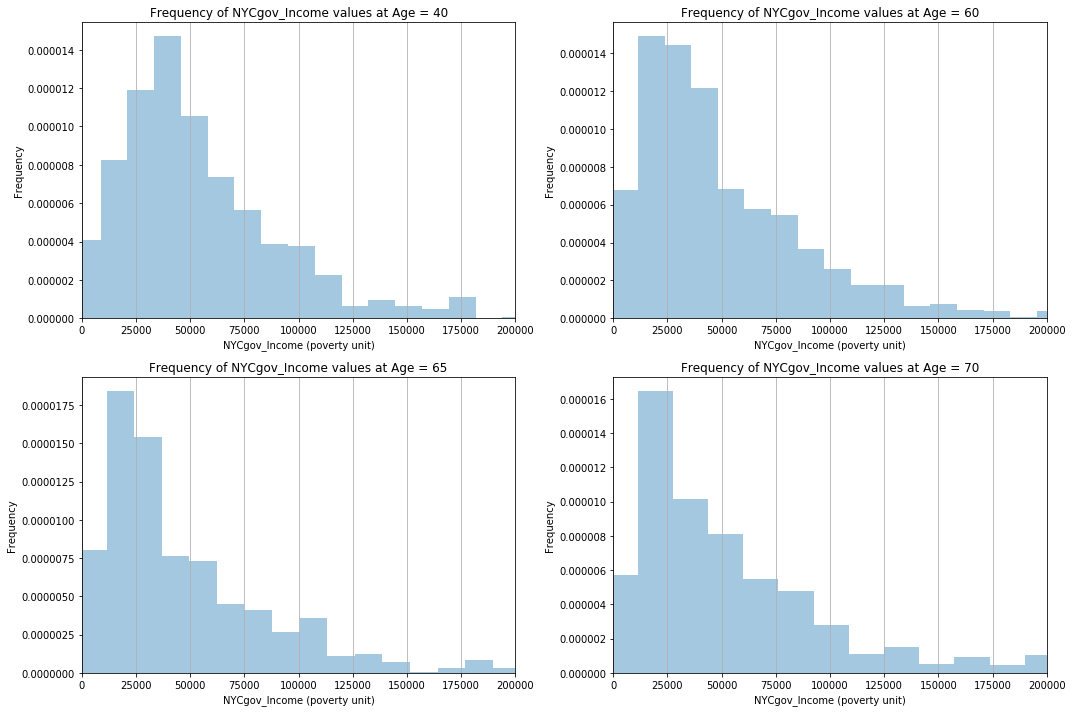

In [163]:
groups = [40, 60, 65, 70]
nrows = 2
ncols = len(groups)//2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10), sharex=True, sharey=True)

for age, axis in zip(groups, range(len(groups))):
    temp = pu_2016[pu_2016.AGEP == age]
    print('Mean of NYCgov_Income at age ' + str(age) + ' : ' + '${:6,.2f}'.format(temp.NYCgov_Income.mean()))
    title = 'Frequency of NYCgov_Income values at Age = ' + str(age)
    plt.subplot(nrows, ncols, axis+1)
    ax = sns.distplot(temp.NYCgov_Income, hist_kws={'weights': temp.WGTP, 'density': 1}, kde=False)
    ax.grid(which='major', axis='x')
    ax.set_xlim(0,200000)
    ax.set_xlabel('NYCgov_Income (poverty unit)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
plt.tight_layout()

***
Here's another quick-and-dirty look at the mean NYCgov_Income by age of the head of the poverty unit.
***

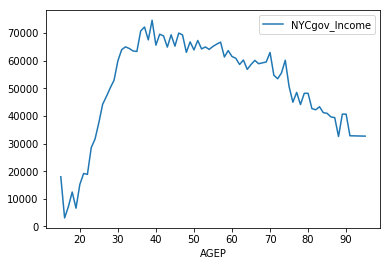

In [169]:
pu_2016[['AGEP', 'NYCgov_Income']].groupby('AGEP').mean().plot()

***
As we'd expect by now, the mean NYCgov_Income in most older age groups is significantly different from other age groups, with a few exceptions.
***

In [158]:
ages = list(range(60,70))

for age1 in ages:
    one = pu_2016[pu_2016.AGEP == age1]
    two = pu_2016[pu_2016.AGEP == age1 - 1]
    comp = CompareMeans.from_data(one.NYCgov_Income, two.NYCgov_Income, weights1=one.WGTP, weights2=two.WGTP)
    print('Comparing age ' + str(age1) + ' to age ' + str(age1-1) + ': ' + str(comp.summary()))

Comparing age 60 to age 59:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -1929.1374    345.469     -5.584      0.000   -2606.251   -1252.024
Comparing age 61 to age 60:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -4257.9865    346.867    -12.276      0.000   -4937.841   -3578.132
Comparing age 62 to age 61:                           Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1  -1404.3971    402.231     -3.492    

WAGP_adj    28826.119248
dtype: float64

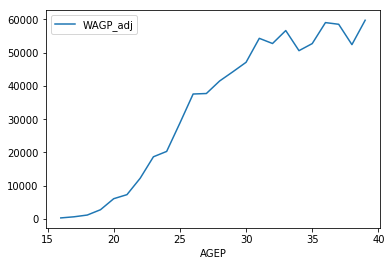

In [71]:
young = df[(df.Year == 2016) & (df.AGEP >= 18) & (df.AGEP <= 30) & (df.WAGP_adj <= 100000)]
#sns.scatterplot(young.AGEP, young.WAGP_adj)
#sns.regplot(young.AGEP, young.WAGP_adj)
#sns.jointplot(young.AGEP, young.WAGP_adj)

df.loc[(df.Year == 2016), ['AGEP', 'WAGP_adj']].groupby('AGEP').mean()[16:40].plot() #6071.
df.loc[(df.Year == 2016) & (df.AGEP == 20), ['WAGP_adj']].mean() #6071.
df.loc[(df.Year == 2016) & (df.AGEP == 25), ['WAGP_adj']].mean() #28826

#sns.jointplot(df[df.Year == 2016].AGEP, df[df.Year == 2016].WAGP_adj, xlim=[18,30], ylim=[0, 10000])
#sns.jointplot(hhonly_2016.AGEP, hhonly_2016.PreTaxIncome_PU, xlim=[18,30], ylim=[0, 750000])
#PreTaxIncome_PU 
#print('Age 18-29:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 18) & (hhonly_2016.AGEP < 30), ['AGEP', 'PreTaxIncome_PU']].corr()))
#print()
#print('Age 30+:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 30), ['AGEP', 'PreTaxIncome_PU']].corr()))

WKHP    34.71258
dtype: float64

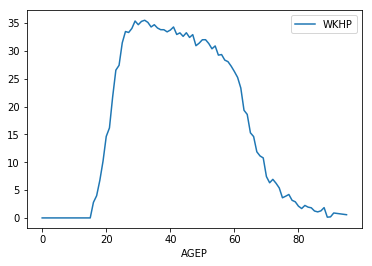

In [90]:
#df.loc[(df.Year == 2016), ['AGEP', 'WKHP']].groupby('AGEP').mean()[16:40].plot() #6071.
df.loc[(df.Year == 2016), ['AGEP', 'WKHP']].groupby('AGEP').mean().plot() #6071.
df.loc[(df.Year == 2016) & (df.AGEP == 20), ['WKHP']].mean() #14.6
df.loc[(df.Year == 2016) & (df.AGEP == 25), ['WKHP']].mean() #31.5
df.loc[(df.Year == 2016) & (df.AGEP == 35), ['WKHP']].mean() #34.7

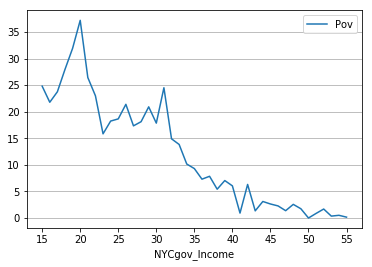

In [358]:
pov_2016 = hhonly_2016.loc[hhonly_2016['NYCgov_Pov_Stat'] == 1]
not_pov_2016 = hhonly_2016.loc[hhonly_2016['NYCgov_Pov_Stat'] == 2]
pov_dist_2016 = sorted(pov_2016.NYCgov_Income)
not_pov_dist_2016 = sorted(not_pov_2016.NYCgov_Income)
#_ = plt.plot(ecdf(pov_dist_2016), marker='.', linestyle='none')
#_ = plt.plot(ecdf(not_pov_dist_2016), marker='.', linestyle='none')
#len(not_pov_2016)
#ecdf(not_pov_dist_2016).index

# Create the charts
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)
                    #for year, axis in zip(years, range(3)):
                    #pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
                    #ax = pcts.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
                    #ax.grid(which='major', axis='y')
                    #plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
#plt.subplot(121)
#ecdf_plot(pov_dist_2016)
#plt.subplot(122)
#ecdf_plot(not_pov_dist_2016)

grouped = hhonly_2016[['NYCgov_Pov_Stat', 'WGTP', 'NYCgov_Income']].groupby([hhonly_2016.NYCgov_Income//1000, 'NYCgov_Pov_Stat']).sum()
counts = grouped.sum(level=0)
pcts = grouped.WGTP/counts.WGTP
pcts = pcts.unstack('NYCgov_Pov_Stat')
counts.tail(-30).head(15) # 18: 43366+16840
#counts.columns
grouped.tail(-30).head(15)
pcts.tail(-30).head(15)

#subtotals = counts.sum(level=0)
    #pcts = 100 * counts / subtotals

thousands = hhonly_2016[['NYCgov_Income', 'NYCgov_Pov_Stat', 'WGTP', 'Povunit_Rel', 'Year']].copy()
thousands['Povunit_Rel'] = 'Head'
thousands['NYCgov_Income'] = thousands.NYCgov_Income // 1000
thousands['NYCgov_Pov_Stat'] = np.where(thousands.NYCgov_Pov_Stat.eq(1), 'Pov', 'Not Pov')
#df_for_pov_chart(thousands, 'NYCgov_Income', 'WGTP').loc[:80].fillna(0).plot()
ax = df_for_pov_chart(thousands, 'NYCgov_Income', 'WGTP').loc[15:55].fillna(0).plot()
#thousands.NYCgov_Income
#??df_for_pov_chart
#bar_sub(thousands, 'NYCgov_Income', [2016])
#??bar_sub
ax.grid(which='major', axis='y')


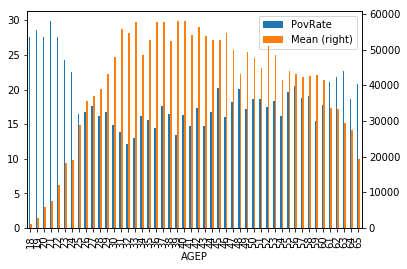

In [24]:
# Put these back in later!
money = cats
money = money.assign(WWAGP = money.WAGP_adj * money.PWGTP)

n = 0
column = raw_inp_vars[n]
weight = 'PWGTP' if column in per_vars else 'WGTP'
df_for_pov_chart(cats, raw_inp_vars[n], weight)
#cats.loc[(cats['AGEP'] >= 18) & (cats['AGEP'] < 65) & (cats['Year'] == 2016),['AGEP', 'WAGP_adj']].groupby('AGEP').describe()
#cats.loc[(cats['AGEP'] >= 18) & (cats['AGEP'] < 65) & (cats['Year'] == 2016),['AGEP', 'WAGP_adj' * 'PWGTP']].groupby('AGEP').describe()

ages_both = money.loc[(money['Year'] == 2016),['AGEP', 'WWAGP', 'PWGTP']].groupby('AGEP').sum()
ages_both['Mean'] = ages_both['WWAGP'] / ages_both['PWGTP']
ages_both['PovRate'] = df_for_pov_chart(cats.loc[cats['Year'] == 2016], raw_inp_vars[n], weight)

#ages_both.loc[(ages_both['AGEP'] >= 18) & (ages_both['AGEP'] < 65), ['PovRate', 'Mean']]
ages_both.loc[18:65, ['PovRate', 'Mean']].plot(kind='bar', secondary_y='Mean')
#ages_both.loc[65:, ['PovRate', 'Mean']].plot(kind='bar', secondary_y='Mean')



#np.average(sales["Current_Price"], weights=sales["Quantity"])
#sales.groupby("Manager").apply(lambda x: np.average(x['New_Product_Price'], weights=x['Quantity']))

#money.loc[(money['AGEP'] >= 18) & (money['AGEP'] < 65)].groupby('AGEP').apply(lambda c: np.average(c['WAGP_adj'], weights=c['PWGTP']))